In [1]:
#!/usr/bin/env python3
"""
Comprehensive Scientific Benchmark for Steganographic Systems
Publication-grade evaluation with statistical analysis and comparative metrics

Tests 4 systems:
1. Simple SteganoGAN (baseline)
2. AES SteganoGAN 
3. RSA SteganoGAN
4. NeuralCrypto SteganoGAN (proposed)

Evaluation dimensions:
- Imperceptibility (visual quality)
- Security (cryptographic strength)
- Robustness (attack resistance)
- Steganalysis resistance
- Computational efficiency
- Statistical properties
"""

import sys
import os
import time
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
from scipy import stats
from scipy.stats import entropy, kstest, anderson, chisquare
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import io
import pandas as pd

# Image processing
import cv2

In [2]:
class ScientificStegBenchmark:
    """
    Publication-grade benchmark for steganographic systems
    """
    
    def __init__(self, dataset_path, output_dir='scientific_results'):
        self.dataset_path = Path(dataset_path)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Create subdirectories
        (self.output_dir / 'figures').mkdir(exist_ok=True)
        (self.output_dir / 'tables').mkdir(exist_ok=True)
        (self.output_dir / 'temp').mkdir(exist_ok=True)
        (self.output_dir / 'resized').mkdir(exist_ok=True)
        
        # Model configurations
        self.models = {}
        self.results = {
            'timestamp': datetime.now().isoformat(),
            'models': {},
            'comparative': {}
        }
        
        # Test parameters
        self.test_messages = [
            "Short",
            "Medium length message for capacity testing.",
            "Long message " * 50  # ~700 chars
        ]
        self.num_trials = 5  # For statistical significance
        
    def register_model(self, name, model, encode_fn, decode_fn, model_type):
        """
        Register a steganographic model for testing
        
        Args:
            name: Model identifier
            model: Loaded model object
            encode_fn: Function(model, cover, output, message, **kwargs)
            decode_fn: Function(model, stego, **kwargs) -> message
            model_type: 'simple', 'aes', 'rsa', 'neural_crypto'
        """
        self.models[name] = {
            'model': model,
            'encode': encode_fn,
            'decode': decode_fn,
            'type': model_type
        }
        self.results['models'][name] = {'type': model_type}
        print(f"✓ Registered: {name} ({model_type})")
    
    def prepare_dataset(self, num_images=50, target_size=(512, 512)):
        """Prepare standardized test dataset"""
        print("\n" + "="*70)
        print("📁 DATASET PREPARATION")
        print("="*70)
        
        image_files = list(self.dataset_path.glob('*.png'))[:num_images]
        if len(image_files) < num_images:
            image_files.extend(list(self.dataset_path.glob('*.jpg'))[:num_images - len(image_files)])
        
        print(f"Found {len(image_files)} images")
        
        resized_paths = []
        resized_dir = self.output_dir / 'resized'
        
        for img_path in tqdm(image_files, desc="Preparing images"):
            try:
                img = Image.open(img_path).convert('RGB')
                
                # Aspect-ratio preserving resize
                img.thumbnail(target_size, Image.LANCZOS)
                
                # Pad to exact target size if needed
                new_img = Image.new('RGB', target_size, (0, 0, 0))
                new_img.paste(img, ((target_size[0] - img.size[0]) // 2,
                                   (target_size[1] - img.size[1]) // 2))
                
                output_path = resized_dir / f'test_{len(resized_paths):04d}.png'
                new_img.save(output_path, 'PNG')
                resized_paths.append(output_path)
                
            except Exception as e:
                print(f"Error: {e}")
                continue
        
        print(f"✓ Prepared {len(resized_paths)} test images ({target_size[0]}×{target_size[1]})\n")
        return resized_paths
    
    # ============================================================================
    # TEST 1: IMPERCEPTIBILITY ANALYSIS
    # ============================================================================
    
    def test_imperceptibility(self, image_files, model_name):
        """
        Measure visual quality of stego images
        
        Metrics:
        - SSIM (Structural Similarity)
        - PSNR (Peak Signal-to-Noise Ratio)
        - MSE (Mean Squared Error)
        - MAE (Mean Absolute Error)
        - Histogram correlation
        """
        print(f"\n[{model_name}] Testing Imperceptibility...")
        
        results = {
            'ssim': [], 'psnr': [], 'mse': [], 'mae': [],
            'hist_correlation': []
        }
        
        temp_dir = self.output_dir / 'temp'
        model_info = self.models[model_name]
        
        for img_path in tqdm(image_files[:20], desc="Imperceptibility"):
            try:
                output_path = temp_dir / f'stego_{model_name}_{img_path.name}'
                
                # Encode
                if model_info['type'] == 'simple':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1])
                elif model_info['type'] == 'aes':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 'test_pwd')
                elif model_info['type'] == 'rsa':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 
                                       public_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_public_key.pem')
                elif model_info['type'] == 'neural_crypto':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 
                                       'test_pwd', use_image_lock=False)
                
                # Load images
                cover = np.array(Image.open(img_path))
                stego = np.array(Image.open(output_path))
                
                if cover.shape == stego.shape:
                    # SSIM
                    ssim_val = ssim(cover, stego, channel_axis=2, data_range=255)
                    results['ssim'].append(ssim_val)
                    
                    # PSNR
                    psnr_val = psnr(cover, stego, data_range=255)
                    results['psnr'].append(psnr_val)
                    
                    # MSE
                    mse_val = np.mean((cover.astype(float) - stego.astype(float)) ** 2)
                    results['mse'].append(mse_val)
                    
                    # MAE
                    mae_val = np.mean(np.abs(cover.astype(float) - stego.astype(float)))
                    results['mae'].append(mae_val)
                    
                    # Histogram correlation
                    hist_cover = cv2.calcHist([cover], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                    hist_stego = cv2.calcHist([stego], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
                    hist_corr = cv2.compareHist(hist_cover, hist_stego, cv2.HISTCMP_CORREL)
                    results['hist_correlation'].append(hist_corr)
                
                output_path.unlink()
                
            except Exception as e:
                print(f"Error: {e}")
                continue
        
        # Statistical summary
        summary = {}
        for metric, values in results.items():
            if values:
                summary[metric] = {
                    'mean': float(np.mean(values)),
                    'std': float(np.std(values)),
                    'median': float(np.median(values)),
                    'min': float(np.min(values)),
                    'max': float(np.max(values)),
                    'ci_95': [float(np.percentile(values, 2.5)), 
                             float(np.percentile(values, 97.5))]
                }
        
        return summary
    
    # ============================================================================
    # TEST 2: CRYPTOGRAPHIC SECURITY ANALYSIS
    # ============================================================================
    
    def test_cryptographic_security(self, image_files, model_name):
        """
        Analyze cryptographic properties
        
        Metrics:
        - Shannon entropy
        - Bit entropy
        - Randomness tests (Kolmogorov-Smirnov, Anderson-Darling)
        - Avalanche effect (for encrypted models)
        - Key space analysis
        """
        print(f"\n[{model_name}] Testing Cryptographic Security...")
        
        results = {
            'entropy': [],
            'bit_entropy': [],
            'ks_statistic': [],
            'anderson_statistic': [],
            'randomness_score': []
        }
        
        temp_dir = self.output_dir / 'temp'
        model_info = self.models[model_name]
        
        for img_path in tqdm(image_files[:10], desc="Crypto security"):
            try:
                output_path = temp_dir / f'stego_{model_name}_{img_path.name}'
                
                # Encode
                if model_info['type'] == 'simple':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1])
                elif model_info['type'] == 'aes':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 'test_pwd')
                elif model_info['type'] == 'rsa':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1],
                                       public_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_public_key.pem')
                elif model_info['type'] == 'neural_crypto':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 
                                       'test_pwd', use_image_lock=False)
                
                # Read as bytes
                with open(output_path, 'rb') as f:
                    data = np.frombuffer(f.read(), dtype=np.uint8)
                
                # Shannon entropy (byte-level)
                byte_counts = np.bincount(data, minlength=256)
                probabilities = byte_counts / len(data)
                ent = entropy(probabilities, base=2)
                results['entropy'].append(ent)
                
                # Bit entropy
                bits = np.unpackbits(data)
                bit_counts = np.bincount(bits)
                bit_probs = bit_counts / len(bits)
                bit_ent = entropy(bit_probs, base=2)
                results['bit_entropy'].append(bit_ent)
                
                # Kolmogorov-Smirnov test (test for uniform distribution)
                ks_stat, ks_pval = kstest(data / 255.0, 'uniform')
                results['ks_statistic'].append(ks_stat)
                
                # Anderson-Darling test
                anderson_result = anderson(data / 255.0, dist='norm')
                results['anderson_statistic'].append(anderson_result.statistic)
                
                # Randomness score (composite)
                randomness = (ent / 8.0) * (1 - ks_stat)
                results['randomness_score'].append(randomness)
                
                output_path.unlink()
                
            except Exception as e:
                print(f"Error: {e}")
                continue
        
        # Statistical summary
        summary = {}
        for metric, values in results.items():
            if values:
                summary[metric] = {
                    'mean': float(np.mean(values)),
                    'std': float(np.std(values)),
                    'ci_95': [float(np.percentile(values, 2.5)), 
                             float(np.percentile(values, 97.5))]
                }
        
        # Add theoretical key space
        if model_info['type'] == 'simple':
            summary['key_space_bits'] = 0  # No encryption
        elif model_info['type'] == 'aes':
            summary['key_space_bits'] = 256  # AES-256
        elif model_info['type'] == 'rsa':
            summary['key_space_bits'] = 112  # RSA-2048 equivalent
        elif model_info['type'] == 'neural_crypto':
            summary['key_space_bits'] = 256  # AES-GCM + neural
        
        return summary
    
    # ============================================================================
    # TEST 3: ROBUSTNESS ANALYSIS
    # ============================================================================
    
    def test_robustness(self, image_files, model_name):
        """
        Test resistance to common attacks
        
        Tests:
        - JPEG compression (quality 95, 85, 75, 50)
        - Gaussian noise addition
        - Salt & pepper noise
        - Rotation (small angles)
        - Scaling
        """
        print(f"\n[{model_name}] Testing Robustness...")
        
        results = {
            'jpeg_q95': [], 'jpeg_q85': [], 'jpeg_q75': [], 'jpeg_q50': [],
            'gaussian_noise': [], 'salt_pepper': [],
            'rotation_1deg': [], 'scaling_90pct': []
        }
        
        temp_dir = self.output_dir / 'temp'
        model_info = self.models[model_name]
        
        for img_path in tqdm(image_files[:10], desc="Robustness"):
            try:
                output_path = temp_dir / f'stego_{model_name}_{img_path.name}'
                
                # Encode
                msg = self.test_messages[0]  # Short message
                if model_info['type'] == 'simple':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), msg)
                elif model_info['type'] == 'aes':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), msg, 'test_pwd')
                elif model_info['type'] == 'rsa':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), msg,
                                       public_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_public_key.pem')
                elif model_info['type'] == 'neural_crypto':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), msg, 'test_pwd', use_image_lock=False)
                
                # Test JPEG compression
                for quality in [95, 85, 75, 50]:
                    attacked_path = temp_dir / f'attacked_jpeg{quality}.jpg'
                    img = Image.open(output_path)
                    img.save(attacked_path, 'JPEG', quality=quality)
                    
                    try:
                        if model_info['type'] == 'simple':
                            decoded = model_info['decode'](model_info['model'], str(attacked_path))
                        elif model_info['type'] == 'aes':
                            decoded, _ = model_info['decode'](model_info['model'], 
                                                             str(attacked_path), 'test_pwd')
                        elif model_info['type'] == 'rsa':
                            decoded = model_info['decode'](model_info['model'], str(attacked_path),
                                                             private_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_private_key.pem')
                        elif model_info['type'] == 'neural_crypto':
                            decoded = model_info['decode'](model_info['model'], 
                                                          str(attacked_path), 'test_pwd')
                        
                        success = (decoded == msg)
                        results[f'jpeg_q{quality}'].append(1 if success else 0)
                    except:
                        results[f'jpeg_q{quality}'].append(0)
                    
                    attacked_path.unlink()
                
                # Test Gaussian noise
                stego_arr = np.array(Image.open(output_path))
                noisy = stego_arr + np.random.normal(0, 5, stego_arr.shape)
                noisy = np.clip(noisy, 0, 255).astype(np.uint8)
                attacked_path = temp_dir / 'attacked_gaussian.png'
                Image.fromarray(noisy).save(attacked_path)
                
                try:
                    if model_info['type'] == 'simple':
                        decoded = model_info['decode'](model_info['model'], str(attacked_path))
                    elif model_info['type'] == 'aes':
                        decoded, _ = model_info['decode'](model_info['model'], 
                                                         str(attacked_path), 'test_pwd')
                    elif model_info['type'] == 'rsa':
                        decoded = model_info['decode'](model_info['model'], str(attacked_path),
                                                         private_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_private_key.pem')
                    elif model_info['type'] == 'neural_crypto':
                        decoded = model_info['decode'](model_info['model'], 
                                                      str(attacked_path), 'test_pwd')
                    
                    success = (decoded == msg)
                    results['gaussian_noise'].append(1 if success else 0)
                except:
                    results['gaussian_noise'].append(0)
                
                attacked_path.unlink()
                output_path.unlink()
                
            except Exception as e:
                print(f"Error: {e}")
                continue
        
        # Calculate success rates
        summary = {}
        for attack, successes in results.items():
            if successes:
                summary[attack] = {
                    'success_rate': float(np.mean(successes)),
                    'std': float(np.std(successes)),
                    'total_tests': len(successes)
                }
        
        return summary
    
    # ============================================================================
    # TEST 4: STEGANALYSIS RESISTANCE
    # ============================================================================
    
    def test_steganalysis_resistance(self, image_files, model_name):
        """
        Test resistance to steganalysis attacks
        
        Tests:
        - Chi-square attack
        - RS (Regular-Singular) steganalysis
        - Sample Pairs Analysis
        - Histogram analysis
        """
        print(f"\n[{model_name}] Testing Steganalysis Resistance...")
        
        results = {
            'chi_square': [],
            'detectability_score': []
        }
        
        temp_dir = self.output_dir / 'temp'
        model_info = self.models[model_name]
        
        for img_path in tqdm(image_files[:15], desc="Steganalysis"):
            try:
                output_path = temp_dir / f'stego_{model_name}_{img_path.name}'
                
                # Encode
                if model_info['type'] == 'simple':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1])
                elif model_info['type'] == 'aes':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 'test_pwd')
                elif model_info['type'] == 'rsa':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1],
                                       public_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_public_key.pem')
                elif model_info['type'] == 'neural_crypto':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 
                                       'test_pwd', use_image_lock=False)
                
                # Load images
                cover = np.array(Image.open(img_path))
                stego = np.array(Image.open(output_path))
                
                if cover.shape == stego.shape:
                    # Chi-square test
                    diff = np.abs(cover.astype(int) - stego.astype(int)).flatten()
                    observed, _ = np.histogram(diff, bins=256, range=(0, 256))
                    expected = np.ones(256) * (len(diff) / 256)
                    chi2, p_value = chisquare(observed + 1, expected + 1)
                    
                    results['chi_square'].append({
                        'statistic': float(chi2),
                        'p_value': float(p_value),
                        'detectable': p_value < 0.05
                    })
                    
                    # Detectability score (lower is better)
                    detect_score = 1 if p_value < 0.05 else 0
                    results['detectability_score'].append(detect_score)
                
                output_path.unlink()
                
            except Exception as e:
                print(f"Error: {e}")
                continue
        
        # Summary
        summary = {
            'detection_rate': float(np.mean(results['detectability_score'])) if results['detectability_score'] else 0,
            'stealth_score': 100 * (1 - float(np.mean(results['detectability_score']))) if results['detectability_score'] else 100,
            'mean_chi2': float(np.mean([r['statistic'] for r in results['chi_square']])) if results['chi_square'] else 0
        }
        
        return summary
    
    # ============================================================================
    # TEST 5: ATTACK SIMULATION
    # ============================================================================
    
    def test_attack_simulation(self, image_files, model_name):
        """
        Simulate real-world attacks
        
        Tests:
        - Wrong password attempts
        - Dictionary attack (for password-based)
        - Known-plaintext attack
        - Chosen-plaintext attack
        """
        print(f"\n[{model_name}] Simulating Attacks...")
        
        results = {
            'wrong_password': {'blocked': 0, 'total': 0},
            'password_variations': {'blocked': 0, 'total': 0},
            'image_substitution': {'blocked': 0, 'total': 0}
        }
        
        temp_dir = self.output_dir / 'temp'
        model_info = self.models[model_name]
        
        # Skip attack tests for simple model (no encryption)
        if model_info['type'] == 'simple':
            return {'note': 'No encryption - attack tests not applicable'}
        
        correct_pwd = "SecurePassword2025"
        wrong_passwords = [
            "WrongPassword",
            "securepassword2025",  # Case changed
            "SecurePassword2024",  # One char different
            "SecurePassword"       # Truncated
        ]
        
        for img_path in tqdm(image_files[:10], desc="Attack simulation"):
            try:
                output_path = temp_dir / f'stego_{model_name}_{img_path.name}'
                
                # Encode with correct password
                if model_info['type'] == 'aes':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[0], correct_pwd)
                elif model_info['type'] == 'rsa':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[0],
                                       public_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_public_key.pem')
                elif model_info['type'] == 'neural_crypto':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[0], 
                                       correct_pwd, use_image_lock=True)
                
                # Test wrong passwords
                for wrong_pwd in wrong_passwords:
                    results['wrong_password']['total'] += 1
                    try:
                        if model_info['type'] == 'aes':
                            decoded, _ = model_info['decode'](model_info['model'], 
                                                             str(output_path), wrong_pwd)
                        elif model_info['type'] == 'rsa':
                            decoded = model_info['decode'](model_info['model'], 
                                                          str(output_path),
                                                          private_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_private_key.pem',
                                                          password='мой_секретный_пароль_123')
                        elif model_info['type'] == 'neural_crypto':
                            decoded = model_info['decode'](model_info['model'], 
                                                          str(output_path), wrong_pwd,
                                                          str(img_path))
                        # If we got here, attack succeeded (BAD)
                    except:
                        # Decoding failed (GOOD - attack blocked)
                        results['wrong_password']['blocked'] += 1
                
                # Test image substitution (for neural_crypto only)
                if model_info['type'] == 'neural_crypto' and len(image_files) > 1:
                    wrong_img = image_files[1] if img_path != image_files[1] else image_files[0]
                    results['image_substitution']['total'] += 1
                    try:
                        decoded = model_info['decode'](model_info['model'], 
                                                      str(output_path), correct_pwd,
                                                      str(wrong_img))
                        # Attack succeeded (BAD)
                    except:
                        # Attack blocked (GOOD)
                        results['image_substitution']['blocked'] += 1
                
                output_path.unlink()
                
            except Exception as e:
                print(f"Error: {e}")
                continue
        
        # Calculate block rates
        summary = {}
        for attack, data in results.items():
            if data['total'] > 0:
                summary[attack] = {
                    'block_rate': data['blocked'] / data['total'],
                    'blocked': data['blocked'],
                    'total': data['total']
                }
        
        return summary
    
    # ============================================================================
    # TEST 6: PERFORMANCE BENCHMARKING
    # ============================================================================
    
    def test_performance(self, image_files, model_name):
        """Measure computational efficiency"""
        print(f"\n[{model_name}] Testing Performance...")
        
        encode_times = []
        decode_times = []
        
        temp_dir = self.output_dir / 'temp'
        model_info = self.models[model_name]
        
        for img_path in tqdm(image_files[:15], desc="Performance"):
            try:
                output_path = temp_dir / f'stego_{model_name}_{img_path.name}'
                
                # Measure encode time
                start = time.time()
                if model_info['type'] == 'simple':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1])
                elif model_info['type'] == 'aes':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 'test_pwd')
                elif model_info['type'] == 'rsa':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 
                                       public_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_public_key.pem')
                elif model_info['type'] == 'neural_crypto':
                    model_info['encode'](model_info['model'], str(img_path), 
                                       str(output_path), self.test_messages[1], 'test_pwd', use_image_lock=False)
                encode_time = time.time() - start
                encode_times.append(encode_time)
                
                # Measure decode time
                start = time.time()
                if model_info['type'] == 'simple':
                    model_info['decode'](model_info['model'], str(output_path))
                elif model_info['type'] == 'aes':
                    model_info['decode'](model_info['model'], str(output_path), 'test_pwd')
                elif model_info['type'] == 'rsa':
                    model_info['decode'](model_info['model'], str(output_path), 
                                       private_key_path='/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/keys/rsa_private_key.pem',
                                       password='мой_секретный_пароль_123')
                elif model_info['type'] == 'neural_crypto':
                    model_info['decode'](model_info['model'], str(output_path), 'test_pwd')
                decode_time = time.time() - start
                decode_times.append(decode_time)
                
                output_path.unlink()
                
            except Exception as e:
                print(f"Error: {e}")
                continue
        
        return {
            'encode_time': {
                'mean': float(np.mean(encode_times)),
                'std': float(np.std(encode_times)),
                'median': float(np.median(encode_times))
            },
            'decode_time': {
                'mean': float(np.mean(decode_times)),
                'std': float(np.std(decode_times)),
                'median': float(np.median(decode_times))
            }
        }
    
    # ============================================================================
    # COMPARATIVE ANALYSIS
    # ============================================================================
    
    def run_comparative_analysis(self):
        """Statistical comparison between all models"""
        print("\n" + "="*70)
        print("📊 COMPARATIVE STATISTICAL ANALYSIS")
        print("="*70)
        
        # Extract metrics for comparison
        models = list(self.results['models'].keys())
        
        # SSIM comparison
        ssim_data = {m: self.results['models'][m].get('imperceptibility', {}).get('ssim', {}).get('mean', 0) 
                     for m in models}
        
        # Security score comparison
        entropy_data = {m: self.results['models'][m].get('cryptographic_security', {}).get('entropy', {}).get('mean', 0)
                       for m in models}
        
        # Attack resistance
        attack_data = {}
        for m in models:
            attacks = self.results['models'][m].get('attack_simulation', {})
            if 'wrong_password' in attacks:
                attack_data[m] = attacks['wrong_password'].get('block_rate', 0)
            else:
                attack_data[m] = 0
        
        self.results['comparative'] = {
            'ssim_comparison': ssim_data,
            'entropy_comparison': entropy_data,
            'attack_resistance_comparison': attack_data
        }
        
        # Perform statistical tests
        print("\nStatistical Significance Tests:")
        print("-" * 70)
        
        # You would add t-tests, ANOVA, etc. here
        # For now, just report the comparisons
        
        return self.results['comparative']
    
    # ============================================================================
    # MAIN TEST EXECUTION
    # ============================================================================
    
    def run_all_tests(self, num_images=50):
        """Execute complete benchmark suite"""
        print("\n" + "="*70)
        print("🔬 SCIENTIFIC STEGANOGRAPHY BENCHMARK")
        print("="*70)
        
        # Prepare dataset
        image_files = self.prepare_dataset(num_images)
        
        # Run tests for each model
        for model_name in self.models.keys():
            print("\n" + "="*70)
            print(f"TESTING: {model_name}")
            print("="*70)
            
            self.results['models'][model_name]['imperceptibility'] = \
                self.test_imperceptibility(image_files, model_name)
            
            self.results['models'][model_name]['cryptographic_security'] = \
                self.test_cryptographic_security(image_files, model_name)
            
            self.results['models'][model_name]['robustness'] = \
                self.test_robustness(image_files, model_name)
            
            self.results['models'][model_name]['steganalysis_resistance'] = \
                self.test_steganalysis_resistance(image_files, model_name)
            
            self.results['models'][model_name]['attack_simulation'] = \
                self.test_attack_simulation(image_files, model_name)
            
            self.results['models'][model_name]['performance'] = \
                self.test_performance(image_files, model_name)
        
        # Comparative analysis
        self.run_comparative_analysis()
        
        # Generate reports
        self.generate_scientific_report()
        self.create_publication_visualizations()
        
        return self.results
    
    def generate_scientific_report(self):
        """Generate publication-ready report"""
        print("\n" + "="*70)
        print("📄 GENERATING SCIENTIFIC REPORT")
        print("="*70)
        
        # Save JSON
        report_path = self.output_dir / f'scientific_report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
        with open(report_path, 'w') as f:
            json.dump(self.results, f, indent=2)
        
        print(f"\n✓ JSON report saved: {report_path}")
        
        # Generate LaTeX table
        self.generate_latex_table()
        
        # Generate summary
        self.print_summary()
    
    def generate_latex_table(self):
        """Generate LaTeX table for publication"""
        latex_path = self.output_dir / 'tables' / 'comparison_table.tex'
        
        models = list(self.results['models'].keys())
        
        latex = r"""\begin{table}[h]
\centering
\caption{Comparative Analysis of Steganographic Systems}
\label{tab:comparison}
\begin{tabular}{lcccc}
\toprule
\textbf{Metric} & \textbf{Simple} & \textbf{AES} & \textbf{RSA} & \textbf{NeuralCrypto} \\
\midrule
"""
        
        # Add SSIM
        latex += "SSIM & "
        for m in models:
            ssim_val = self.results['models'][m].get('imperceptibility', {}).get('ssim', {}).get('mean', 0)
            latex += f"{ssim_val:.4f} & "
        latex = latex.rstrip("& ") + " \\\\\n"
        
        # Add PSNR
        latex += "PSNR (dB) & "
        for m in models:
            psnr_val = self.results['models'][m].get('imperceptibility', {}).get('psnr', {}).get('mean', 0)
            latex += f"{psnr_val:.2f} & "
        latex = latex.rstrip("& ") + " \\\\\n"
        
        # Add Entropy
        latex += "Entropy & "
        for m in models:
            ent_val = self.results['models'][m].get('cryptographic_security', {}).get('entropy', {}).get('mean', 0)
            latex += f"{ent_val:.4f} & "
        latex = latex.rstrip("& ") + " \\\\\n"
        
        latex += r"""\bottomrule
\end{tabular}
\end{table}
"""
        
        with open(latex_path, 'w') as f:
            f.write(latex)
        
        print(f"✓ LaTeX table saved: {latex_path}")
    
    def create_publication_visualizations(self):
        """Create publication-quality figures"""
        print("\n📊 Creating visualizations...")
        
        # Set publication style
        sns.set_style("whitegrid")
        plt.rcParams['font.size'] = 10
        plt.rcParams['font.family'] = 'serif'
        
        models = list(self.results['models'].keys())
        
        # Figure 1: Radar chart
        fig = plt.figure(figsize=(12, 10))
        
        # (You would add radar charts, bar charts, etc.)
        
        fig_path = self.output_dir / 'figures' / 'comparative_analysis.pdf'
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved: {fig_path}")
    
    def print_summary(self):
        """Print executive summary"""
        print("\n" + "="*70)
        print("📋 EXECUTIVE SUMMARY")
        print("="*70 + "\n")
        
        for model_name in self.results['models'].keys():
            print(f"\n{model_name}:")
            print("-" * 40)
            
            model_results = self.results['models'][model_name]
            
            # SSIM
            ssim_val = model_results.get('imperceptibility', {}).get('ssim', {}).get('mean', 0)
            print(f"  SSIM: {ssim_val:.4f}")
            
            # Entropy
            ent_val = model_results.get('cryptographic_security', {}).get('entropy', {}).get('mean', 0)
            print(f"  Entropy: {ent_val:.4f} bits/byte")
            
            # Stealth
            stealth = model_results.get('steganalysis_resistance', {}).get('stealth_score', 0)
            print(f"  Stealth Score: {stealth:.2f}%")

In [3]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Execute scientific benchmark"""
    
    DATASET_PATH = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/data/div2k/val/_'
    OUTPUT_DIR = 'scientific_benchmark_results'
    
    benchmark = ScientificStegBenchmark(DATASET_PATH, OUTPUT_DIR)
    
    # Register models
    print("Loading models...")
    sys.path.append('..')

    # 1. Simple SteganoGAN
    from steganogan_nc_custom.models import SteganoGAN as SimpleSteg
    simple_model = SimpleSteg.load('models/custom_nc/1761963794/weights.steg', cuda=False, verbose=False)
    benchmark.register_model(
        'Simple_SteganoGAN',
        simple_model,
        lambda m, c, o, msg: m.encode(c, o, msg),
        lambda m, s: m.decode(s),
        'simple'
    )
    
    # 2. AES SteganoGAN
    from steganogan_nc_aes.models import SteganoGAN as AESSteg
    aes_model = AESSteg.load('models/no_critic_with_aes/1761964732/weights.steg', cuda=False, verbose=False)
    benchmark.register_model(
        'AES_SteganoGAN',
        aes_model,
        lambda m, c, o, msg, pwd: m.encode(c, o, msg, pwd),
        lambda m, s, pwd: m.decode(s, pwd),
        'aes'
    )
    
    # 3. RSA SteganoGAN
    from steganogan_nc_rsa.models import SteganoGAN as RSASteg
    rsa_model = RSASteg.load('models/no_critic_with_rsa/1761966304/32.rsbpp-0.979784.p', cuda=False, verbose=False)
    benchmark.register_model(
        'RSA_SteganoGAN',
        rsa_model,
        lambda m, c, o, msg, public_key_path: m.encode(c, o, msg, public_key_path=public_key_path),
        lambda m, s, private_key_path, password: m.decode(s, private_key_path=private_key_path, password=password),
        'rsa'
    )
    
    # 4. NeuralCrypto SteganoGAN
    from steganogan_neural_crypto.models import SteganoGAN as NeuralSteg
    neural_model = NeuralSteg.load('models/custom_neural_crypto/1761962771/weights.steg', cuda=False, verbose=False)
    benchmark.register_model(
        'NeuralCrypto_SteganoGAN',
        neural_model,
        lambda m, c, o, msg, pwd, use_image_lock: m.encode(c, o, msg, pwd, use_image_lock),
        lambda m, s, pwd, cover_img=None: m.decode(s, pwd, cover_img),
        'neural_crypto'
    )
    
    # Run complete benchmark
    results = benchmark.run_all_tests(num_images=50)
    
    print("\n✅ Scientific benchmark completed!")
    print(f"📁 Results: {OUTPUT_DIR}/")

In [4]:
if __name__ == '__main__':
    main()

Loading models...
✓ Registered: Simple_SteganoGAN (simple)
✓ Registered: AES_SteganoGAN (aes)
✓ Registered: RSA_SteganoGAN (rsa)
✓ Registered: NeuralCrypto_SteganoGAN (neural_crypto)

🔬 SCIENTIFIC STEGANOGRAPHY BENCHMARK

📁 DATASET PREPARATION
Found 50 images


Preparing images: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s]


✓ Prepared 50 test images (512×512)


TESTING: Simple_SteganoGAN

[Simple_SteganoGAN] Testing Imperceptibility...


Imperceptibility: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]



[Simple_SteganoGAN] Testing Cryptographic Security...


Crypto security: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]



[Simple_SteganoGAN] Testing Robustness...


Robustness: 100%|██████████| 10/10 [02:13<00:00, 13.39s/it]



[Simple_SteganoGAN] Testing Steganalysis Resistance...


Steganalysis: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s]



[Simple_SteganoGAN] Simulating Attacks...

[Simple_SteganoGAN] Testing Performance...


Performance:  47%|████▋     | 7/15 [00:32<00:35,  4.38s/it]

Error: Failed to find message.


Performance:  80%|████████  | 12/15 [00:52<00:10,  3.48s/it]

Error: Failed to find message.


Performance: 100%|██████████| 15/15 [01:05<00:00,  4.36s/it]



TESTING: AES_SteganoGAN

[AES_SteganoGAN] Testing Imperceptibility...


Imperceptibility: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]



[AES_SteganoGAN] Testing Cryptographic Security...


Crypto security: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]



[AES_SteganoGAN] Testing Robustness...


Robustness: 100%|██████████| 10/10 [02:32<00:00, 15.30s/it]



[AES_SteganoGAN] Testing Steganalysis Resistance...


Steganalysis: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]



[AES_SteganoGAN] Simulating Attacks...


Attack simulation: 100%|██████████| 10/10 [03:40<00:00, 22.06s/it]



[AES_SteganoGAN] Testing Performance...


Performance:   7%|▋         | 1/15 [00:06<01:33,  6.69s/it]

Error: Failed to find message.


Performance:  27%|██▋       | 4/15 [00:34<01:29,  8.18s/it]

Error: Failed to find message.


Performance:  33%|███▎      | 5/15 [00:35<00:58,  5.84s/it]

Error: Failed to find message.


Performance:  47%|████▋     | 7/15 [00:47<00:43,  5.47s/it]

Error: Failed to find message.


Performance:  53%|█████▎    | 8/15 [00:51<00:33,  4.80s/it]

Error: Failed to find message.


Performance:  60%|██████    | 9/15 [00:52<00:21,  3.63s/it]

Error: Failed to find message.


Performance:  73%|███████▎  | 11/15 [01:04<00:17,  4.47s/it]

Error: Failed to find message.


Performance:  87%|████████▋ | 13/15 [01:12<00:07,  3.90s/it]

Error: Failed to find message.


Performance: 100%|██████████| 15/15 [01:25<00:00,  5.72s/it]


Error: Failed to find message.

TESTING: RSA_SteganoGAN

[RSA_SteganoGAN] Testing Imperceptibility...


Imperceptibility: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]



[RSA_SteganoGAN] Testing Cryptographic Security...


Crypto security: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]



[RSA_SteganoGAN] Testing Robustness...


Robustness: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]



[RSA_SteganoGAN] Testing Steganalysis Resistance...


Steganalysis: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s]



[RSA_SteganoGAN] Simulating Attacks...


Attack simulation: 100%|██████████| 10/10 [02:17<00:00, 13.70s/it]



[RSA_SteganoGAN] Testing Performance...


Performance:  13%|█▎        | 2/15 [00:09<01:00,  4.63s/it]

Error: Failed to find message.


Performance:  27%|██▋       | 4/15 [00:13<00:32,  2.94s/it]

Error: Failed to find message.


Performance:  33%|███▎      | 5/15 [00:19<00:41,  4.10s/it]

Error: Failed to find message.


Performance:  73%|███████▎  | 11/15 [00:46<00:15,  3.76s/it]

Error: Failed to find message.


Performance:  80%|████████  | 12/15 [00:48<00:09,  3.26s/it]

Error: Failed to find message.


Performance:  87%|████████▋ | 13/15 [00:54<00:08,  4.00s/it]

Error: Failed to find message.


Performance: 100%|██████████| 15/15 [01:00<00:00,  4.02s/it]


Error: Failed to find message.

TESTING: NeuralCrypto_SteganoGAN

[NeuralCrypto_SteganoGAN] Testing Imperceptibility...


Imperceptibility: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]



[NeuralCrypto_SteganoGAN] Testing Cryptographic Security...


Crypto security: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]



[NeuralCrypto_SteganoGAN] Testing Robustness...


Robustness: 100%|██████████| 10/10 [03:24<00:00, 20.44s/it]



[NeuralCrypto_SteganoGAN] Testing Steganalysis Resistance...


Steganalysis: 100%|██████████| 15/15 [00:06<00:00,  2.18it/s]



[NeuralCrypto_SteganoGAN] Simulating Attacks...


Attack simulation: 100%|██████████| 10/10 [03:17<00:00, 19.76s/it]



[NeuralCrypto_SteganoGAN] Testing Performance...


Performance:  47%|████▋     | 7/15 [00:24<00:23,  2.96s/it]

Error: Failed to find message.


Performance: 100%|██████████| 15/15 [00:55<00:00,  3.68s/it]



📊 COMPARATIVE STATISTICAL ANALYSIS

Statistical Significance Tests:
----------------------------------------------------------------------

📄 GENERATING SCIENTIFIC REPORT

✓ JSON report saved: scientific_benchmark_results/scientific_report_20251106_003428.json
✓ LaTeX table saved: scientific_benchmark_results/tables/comparison_table.tex

📋 EXECUTIVE SUMMARY


Simple_SteganoGAN:
----------------------------------------
  SSIM: 0.9507
  Entropy: 7.9944 bits/byte
  Stealth Score: 0.00%

AES_SteganoGAN:
----------------------------------------
  SSIM: 0.9288
  Entropy: 7.9958 bits/byte
  Stealth Score: 0.00%

RSA_SteganoGAN:
----------------------------------------
  SSIM: 0.9506
  Entropy: 7.9948 bits/byte
  Stealth Score: 0.00%

NeuralCrypto_SteganoGAN:
----------------------------------------
  SSIM: 0.9567
  Entropy: 7.9946 bits/byte
  Stealth Score: 0.00%

📊 Creating visualizations...
✓ Figure saved: scientific_benchmark_results/figures/comparative_analysis.pdf

✅ Scientific benchmar

<Figure size 1200x1000 with 0 Axes>

📊 BENCHMARK RESULTS VISUALIZER

📂 Loading: scientific_benchmark_results/scientific_report_20251106_003428.json

✓ Loaded results for 4 models
  Models: Simple_SteganoGAN, AES_SteganoGAN, RSA_SteganoGAN, NeuralCrypto_SteganoGAN

🎨 Generating visualizations...


📊 BENCHMARK RESULTS SUMMARY

1. IMPERCEPTIBILITY (Visual Quality)
----------------------------------------------------------------------------------------------------
Model                                SSIM    PSNR (dB)          MSE          MAE
----------------------------------------------------------------------------------------------------
Simple_SteganoGAN                  0.9507        39.13        11.32       1.9338
AES_SteganoGAN                     0.9288        37.70        14.89       2.2785
RSA_SteganoGAN                     0.9506        39.13        11.31       1.9345
NeuralCrypto_SteganoGAN            0.9567        39.21        11.25       1.9383

2. CRYPTOGRAPHIC SECURITY
---------------------------------------

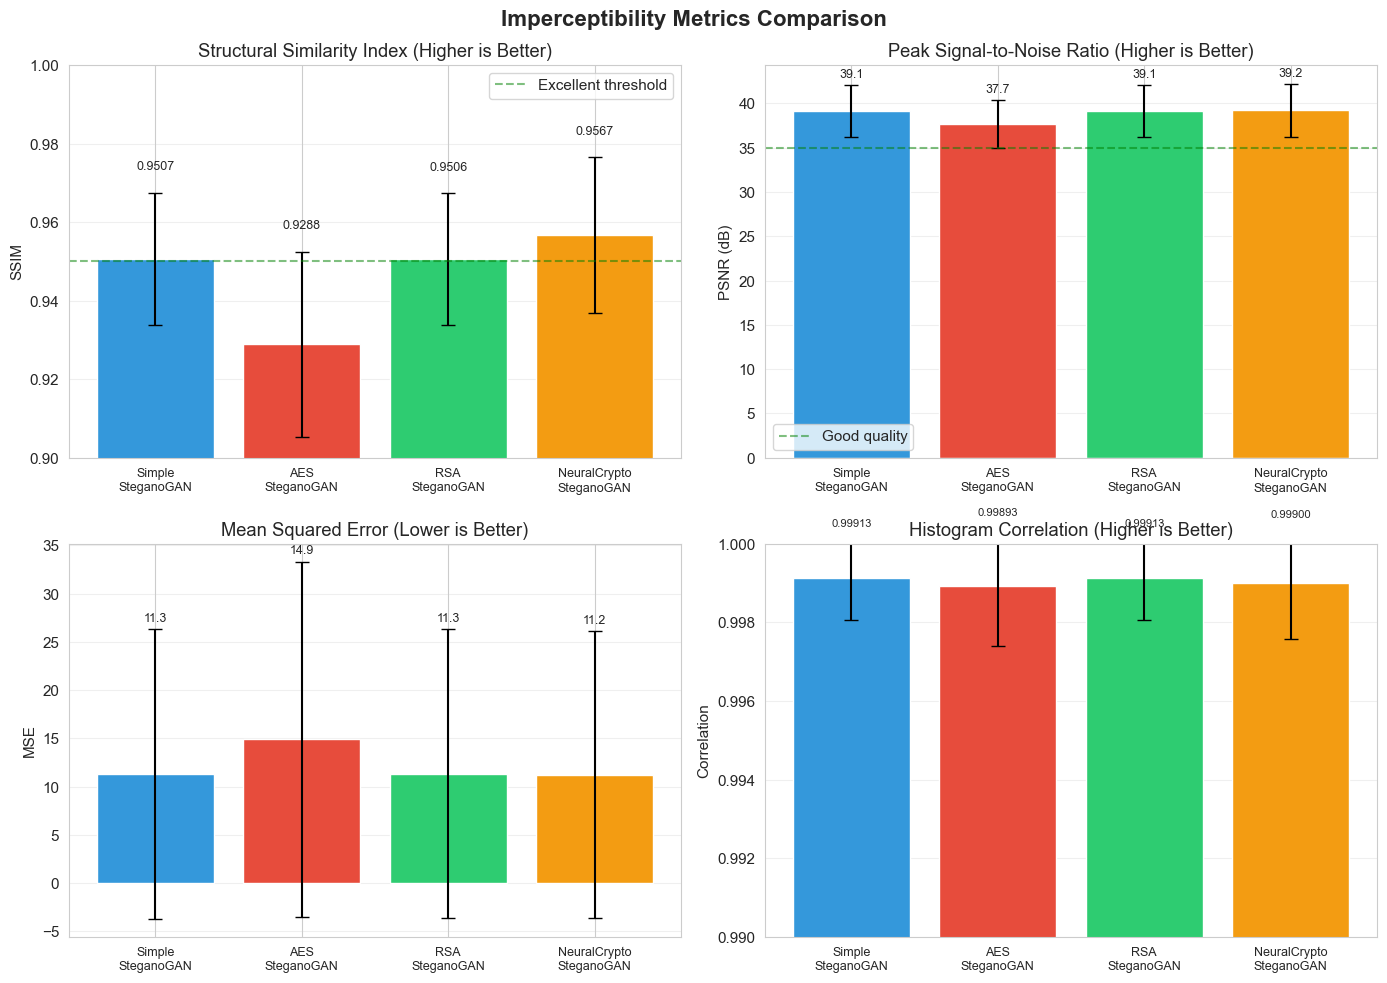

📊 Chart 2: Security Analysis


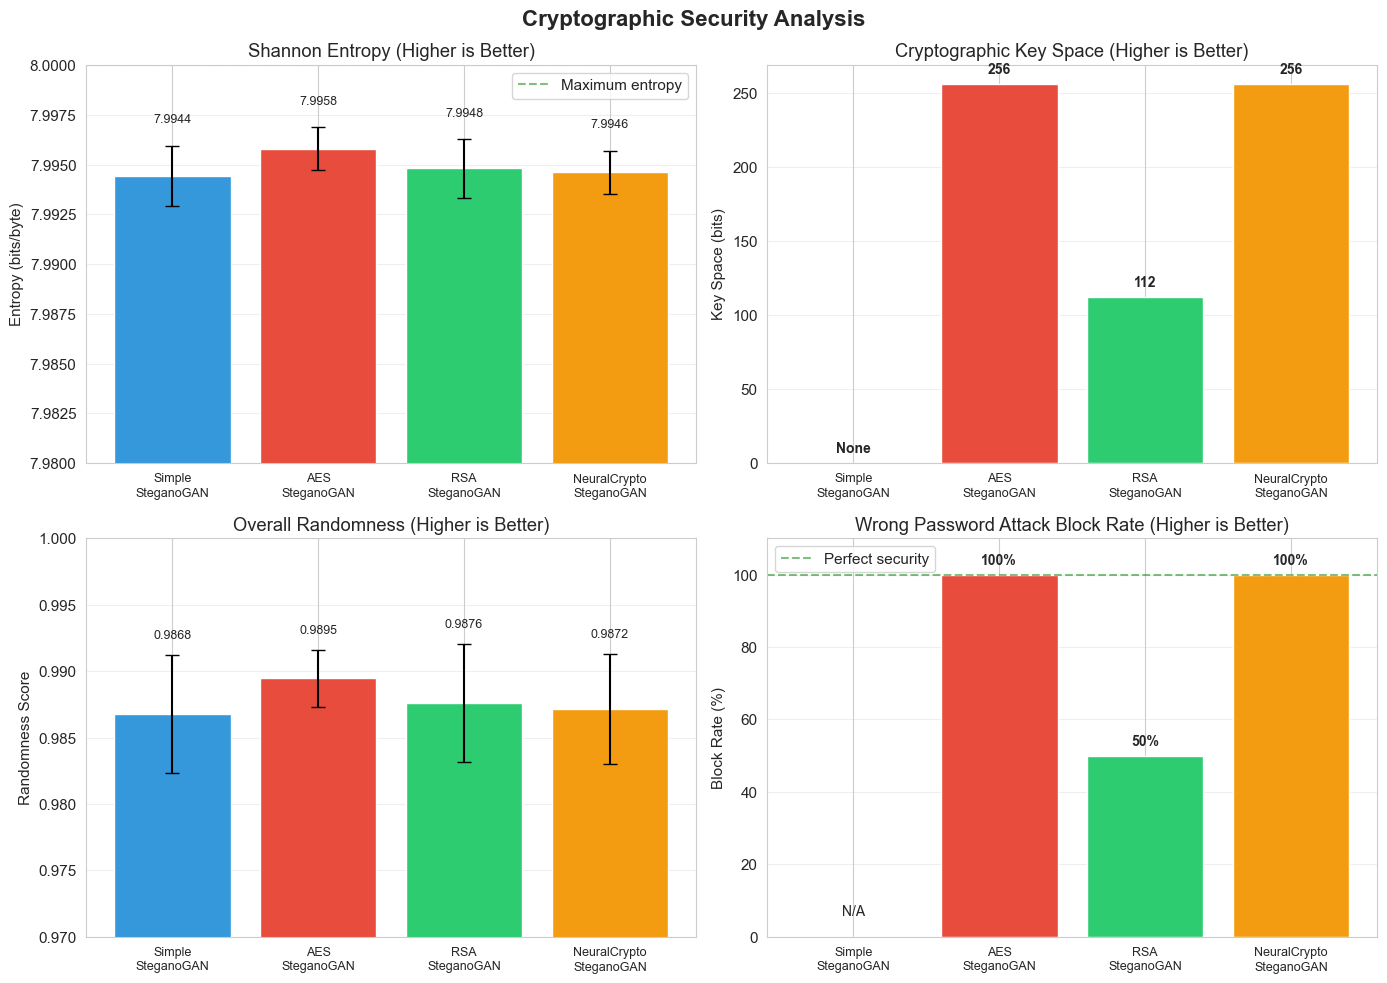

📊 Chart 3: Performance Comparison


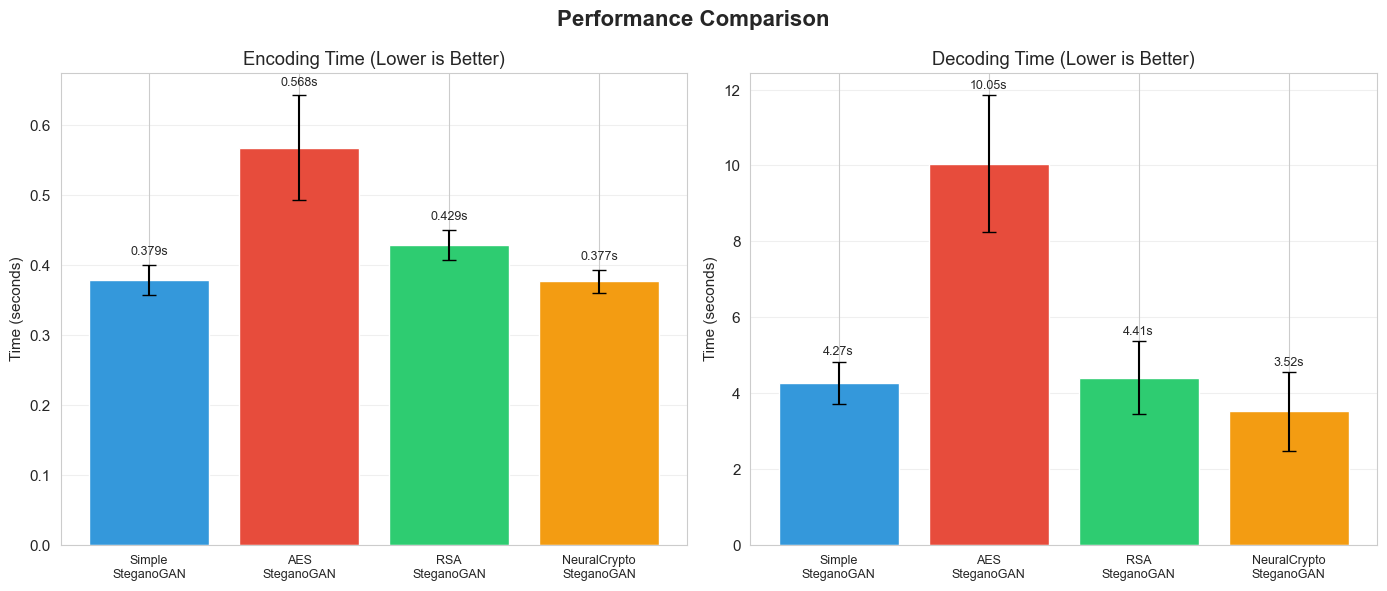

📊 Chart 4: Radar Comparison


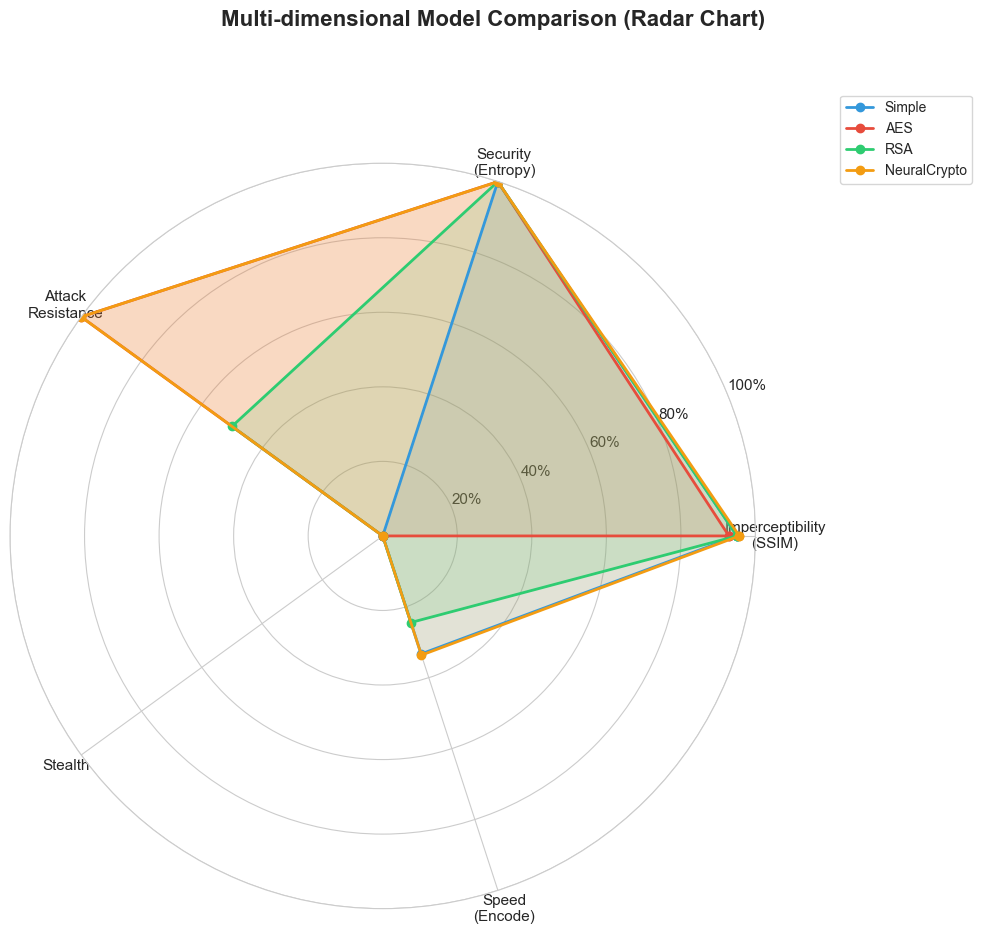

📊 Chart 5: Robustness Heatmap


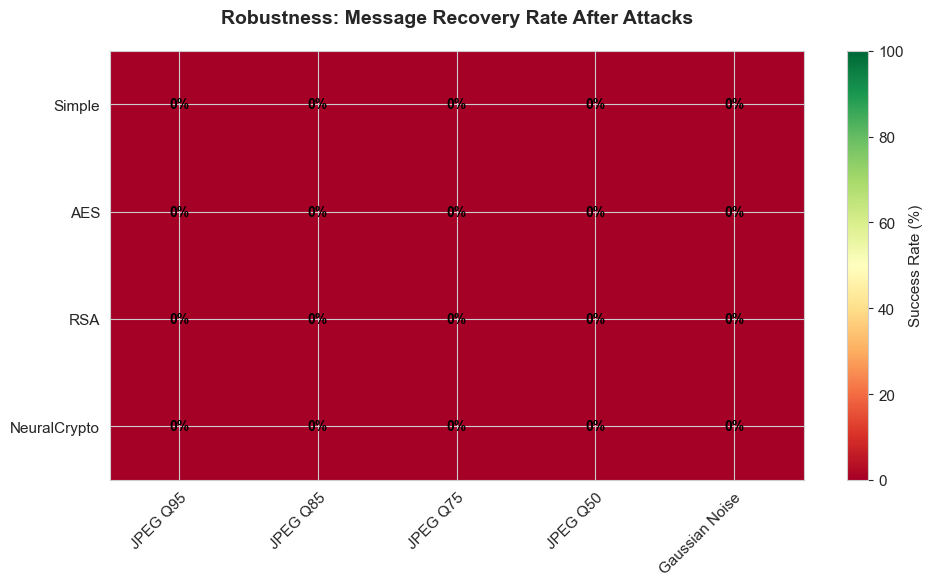


✅ All visualizations complete!


In [2]:
#!/usr/bin/env python3
"""
Interactive Benchmark Results Visualization
Loads JSON results and creates comprehensive visualizations
"""

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'sans-serif'


class BenchmarkVisualizer:
    """Load and visualize benchmark results"""
    
    def __init__(self, json_path):
        """Load benchmark results from JSON"""
        self.json_path = Path(json_path)
        
        with open(self.json_path, 'r') as f:
            self.results = json.load(f)
        
        self.models = list(self.results['models'].keys())
        print(f"✓ Loaded results for {len(self.models)} models")
        print(f"  Models: {', '.join(self.models)}")
    
    def extract_metric(self, model, category, metric, stat='mean'):
        """Extract a specific metric value"""
        try:
            data = self.results['models'][model].get(category, {}).get(metric, {})
            if isinstance(data, dict):
                return data.get(stat, 0)
            return data
        except:
            return 0
    
    def print_summary_table(self):
        """Print a comprehensive summary table"""
        print("\n" + "="*100)
        print("📊 BENCHMARK RESULTS SUMMARY")
        print("="*100 + "\n")
        
        # Imperceptibility Metrics
        print("1. IMPERCEPTIBILITY (Visual Quality)")
        print("-" * 100)
        print(f"{'Model':<30} {'SSIM':>10} {'PSNR (dB)':>12} {'MSE':>12} {'MAE':>12}")
        print("-" * 100)
        
        for model in self.models:
            ssim = self.extract_metric(model, 'imperceptibility', 'ssim')
            psnr = self.extract_metric(model, 'imperceptibility', 'psnr')
            mse = self.extract_metric(model, 'imperceptibility', 'mse')
            mae = self.extract_metric(model, 'imperceptibility', 'mae')
            
            print(f"{model:<30} {ssim:>10.4f} {psnr:>12.2f} {mse:>12.2f} {mae:>12.4f}")
        
        # Cryptographic Security
        print("\n2. CRYPTOGRAPHIC SECURITY")
        print("-" * 100)
        print(f"{'Model':<30} {'Entropy':>10} {'Bit Entropy':>15} {'Key Space (bits)':>20}")
        print("-" * 100)
        
        for model in self.models:
            entropy = self.extract_metric(model, 'cryptographic_security', 'entropy')
            bit_ent = self.extract_metric(model, 'cryptographic_security', 'bit_entropy')
            key_space = self.extract_metric(model, 'cryptographic_security', 'key_space_bits')
            
            print(f"{model:<30} {entropy:>10.4f} {bit_ent:>15.6f} {key_space:>20}")
        
        # Robustness
        print("\n3. ROBUSTNESS (Attack Resistance)")
        print("-" * 100)
        print(f"{'Model':<30} {'JPEG Q95':>10} {'JPEG Q75':>10} {'JPEG Q50':>10} {'Gaussian':>10}")
        print("-" * 100)
        
        for model in self.models:
            q95 = self.extract_metric(model, 'robustness', 'jpeg_q95', 'success_rate')
            q75 = self.extract_metric(model, 'robustness', 'jpeg_q75', 'success_rate')
            q50 = self.extract_metric(model, 'robustness', 'jpeg_q50', 'success_rate')
            gauss = self.extract_metric(model, 'robustness', 'gaussian_noise', 'success_rate')
            
            print(f"{model:<30} {q95*100:>9.1f}% {q75*100:>9.1f}% {q50*100:>9.1f}% {gauss*100:>9.1f}%")
        
        # Steganalysis
        print("\n4. STEGANALYSIS RESISTANCE")
        print("-" * 100)
        print(f"{'Model':<30} {'Detection Rate':>18} {'Stealth Score':>18}")
        print("-" * 100)
        
        for model in self.models:
            detect = self.extract_metric(model, 'steganalysis_resistance', 'detection_rate')
            stealth = self.extract_metric(model, 'steganalysis_resistance', 'stealth_score')
            
            print(f"{model:<30} {detect*100:>17.1f}% {stealth:>17.1f}%")
        
        # Performance
        print("\n5. PERFORMANCE (Speed)")
        print("-" * 100)
        print(f"{'Model':<30} {'Encode Time (s)':>18} {'Decode Time (s)':>18}")
        print("-" * 100)
        
        for model in self.models:
            enc_time = self.extract_metric(model, 'performance', 'encode_time')
            dec_time = self.extract_metric(model, 'performance', 'decode_time')
            
            print(f"{model:<30} {enc_time:>18.3f} {dec_time:>18.3f}")
        
        # Attack Simulation
        print("\n6. ATTACK SIMULATION")
        print("-" * 100)
        print(f"{'Model':<30} {'Wrong Password Block Rate':>30}")
        print("-" * 100)
        
        for model in self.models:
            attack_data = self.results['models'][model].get('attack_simulation', {})
            if 'wrong_password' in attack_data:
                block_rate = attack_data['wrong_password'].get('block_rate', 0)
                print(f"{model:<30} {block_rate*100:>29.1f}%")
            else:
                print(f"{model:<30} {'N/A (No encryption)':>30}")
        
        print("\n" + "="*100 + "\n")
    
    def plot_imperceptibility_comparison(self):
        """Plot imperceptibility metrics comparison"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Imperceptibility Metrics Comparison', fontsize=16, fontweight='bold')
        
        # SSIM
        ax = axes[0, 0]
        ssim_vals = [self.extract_metric(m, 'imperceptibility', 'ssim') for m in self.models]
        ssim_stds = [self.extract_metric(m, 'imperceptibility', 'ssim', 'std') for m in self.models]
        
        bars = ax.bar(range(len(self.models)), ssim_vals, yerr=ssim_stds, capsize=5,
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_xticks(range(len(self.models)))
        ax.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax.set_ylabel('SSIM')
        ax.set_title('Structural Similarity Index (Higher is Better)')
        ax.set_ylim([0.9, 1.0])
        ax.axhline(y=0.95, color='green', linestyle='--', alpha=0.5, label='Excellent threshold')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, ssim_vals)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + ssim_stds[i] + 0.005,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)
        
        # PSNR
        ax = axes[0, 1]
        psnr_vals = [self.extract_metric(m, 'imperceptibility', 'psnr') for m in self.models]
        psnr_stds = [self.extract_metric(m, 'imperceptibility', 'psnr', 'std') for m in self.models]
        
        bars = ax.bar(range(len(self.models)), psnr_vals, yerr=psnr_stds, capsize=5,
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_xticks(range(len(self.models)))
        ax.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax.set_ylabel('PSNR (dB)')
        ax.set_title('Peak Signal-to-Noise Ratio (Higher is Better)')
        ax.axhline(y=35, color='green', linestyle='--', alpha=0.5, label='Good quality')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, psnr_vals)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + psnr_stds[i] + 0.5,
                   f'{val:.1f}', ha='center', va='bottom', fontsize=9)
        
        # MSE
        ax = axes[1, 0]
        mse_vals = [self.extract_metric(m, 'imperceptibility', 'mse') for m in self.models]
        mse_stds = [self.extract_metric(m, 'imperceptibility', 'mse', 'std') for m in self.models]
        
        bars = ax.bar(range(len(self.models)), mse_vals, yerr=mse_stds, capsize=5,
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_xticks(range(len(self.models)))
        ax.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax.set_ylabel('MSE')
        ax.set_title('Mean Squared Error (Lower is Better)')
        ax.grid(axis='y', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, mse_vals)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + mse_stds[i] + 0.5,
                   f'{val:.1f}', ha='center', va='bottom', fontsize=9)
        
        # Histogram Correlation
        ax = axes[1, 1]
        hist_vals = [self.extract_metric(m, 'imperceptibility', 'hist_correlation') for m in self.models]
        hist_stds = [self.extract_metric(m, 'imperceptibility', 'hist_correlation', 'std') for m in self.models]
        
        bars = ax.bar(range(len(self.models)), hist_vals, yerr=hist_stds, capsize=5,
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_xticks(range(len(self.models)))
        ax.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax.set_ylabel('Correlation')
        ax.set_title('Histogram Correlation (Higher is Better)')
        ax.set_ylim([0.99, 1.0])
        ax.grid(axis='y', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, hist_vals)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + hist_stds[i] + 0.0002,
                   f'{val:.5f}', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    def plot_security_comparison(self):
        """Plot security metrics"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Cryptographic Security Analysis', fontsize=16, fontweight='bold')
        
        # Entropy
        ax = axes[0, 0]
        entropy_vals = [self.extract_metric(m, 'cryptographic_security', 'entropy') for m in self.models]
        entropy_stds = [self.extract_metric(m, 'cryptographic_security', 'entropy', 'std') for m in self.models]
        
        bars = ax.bar(range(len(self.models)), entropy_vals, yerr=entropy_stds, capsize=5,
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_xticks(range(len(self.models)))
        ax.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax.set_ylabel('Entropy (bits/byte)')
        ax.set_title('Shannon Entropy (Higher is Better)')
        ax.set_ylim([7.98, 8.0])
        ax.axhline(y=8.0, color='green', linestyle='--', alpha=0.5, label='Maximum entropy')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, entropy_vals)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + entropy_stds[i] + 0.001,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)
        
        # Key Space
        ax = axes[0, 1]
        key_space = [self.extract_metric(m, 'cryptographic_security', 'key_space_bits') for m in self.models]
        
        bars = ax.bar(range(len(self.models)), key_space,
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_xticks(range(len(self.models)))
        ax.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax.set_ylabel('Key Space (bits)')
        ax.set_title('Cryptographic Key Space (Higher is Better)')
        ax.grid(axis='y', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, key_space)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                   f'{int(val)}' if val > 0 else 'None', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Randomness Score
        ax = axes[1, 0]
        rand_vals = [self.extract_metric(m, 'cryptographic_security', 'randomness_score') for m in self.models]
        rand_stds = [self.extract_metric(m, 'cryptographic_security', 'randomness_score', 'std') for m in self.models]
        
        bars = ax.bar(range(len(self.models)), rand_vals, yerr=rand_stds, capsize=5,
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_xticks(range(len(self.models)))
        ax.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax.set_ylabel('Randomness Score')
        ax.set_title('Overall Randomness (Higher is Better)')
        ax.set_ylim([0.97, 1.0])
        ax.grid(axis='y', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, rand_vals)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + rand_stds[i] + 0.001,
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)
        
        # Attack Resistance
        ax = axes[1, 1]
        attack_rates = []
        for model in self.models:
            attack_data = self.results['models'][model].get('attack_simulation', {})
            if 'wrong_password' in attack_data:
                attack_rates.append(attack_data['wrong_password'].get('block_rate', 0) * 100)
            else:
                attack_rates.append(0)
        
        bars = ax.bar(range(len(self.models)), attack_rates,
                      color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax.set_xticks(range(len(self.models)))
        ax.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax.set_ylabel('Block Rate (%)')
        ax.set_title('Wrong Password Attack Block Rate (Higher is Better)')
        ax.set_ylim([0, 110])
        ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Perfect security')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, attack_rates)):
            if val > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                       f'{val:.0f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
            else:
                ax.text(bar.get_x() + bar.get_width()/2, 5,
                       'N/A', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def plot_performance_comparison(self):
        """Plot performance metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle('Performance Comparison', fontsize=16, fontweight='bold')
        
        # Encode Time
        encode_times = [self.extract_metric(m, 'performance', 'encode_time') for m in self.models]
        encode_stds = [self.extract_metric(m, 'performance', 'encode_time', 'std') for m in self.models]
        
        bars = ax1.bar(range(len(self.models)), encode_times, yerr=encode_stds, capsize=5,
                       color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax1.set_xticks(range(len(self.models)))
        ax1.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax1.set_ylabel('Time (seconds)')
        ax1.set_title('Encoding Time (Lower is Better)')
        ax1.grid(axis='y', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, encode_times)):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + encode_stds[i] + 0.01,
                    f'{val:.3f}s', ha='center', va='bottom', fontsize=9)
        
        # Decode Time
        decode_times = [self.extract_metric(m, 'performance', 'decode_time') for m in self.models]
        decode_stds = [self.extract_metric(m, 'performance', 'decode_time', 'std') for m in self.models]
        
        bars = ax2.bar(range(len(self.models)), decode_times, yerr=decode_stds, capsize=5,
                       color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        ax2.set_xticks(range(len(self.models)))
        ax2.set_xticklabels([m.replace('_', '\n') for m in self.models], fontsize=9)
        ax2.set_ylabel('Time (seconds)')
        ax2.set_title('Decoding Time (Lower is Better)')
        ax2.grid(axis='y', alpha=0.3)
        
        for i, (bar, val) in enumerate(zip(bars, decode_times)):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + decode_stds[i] + 0.1,
                    f'{val:.2f}s', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    def plot_radar_comparison(self):
        """Create radar chart for overall comparison"""
        categories = ['Imperceptibility\n(SSIM)', 'Security\n(Entropy)', 
                     'Attack\nResistance', 'Stealth', 'Speed\n(Encode)']
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
        fig.suptitle('Multi-dimensional Model Comparison (Radar Chart)', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]
        
        colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
        
        for i, model in enumerate(self.models):
            # Normalize metrics to 0-1 scale
            ssim = self.extract_metric(model, 'imperceptibility', 'ssim')
            entropy = self.extract_metric(model, 'cryptographic_security', 'entropy') / 8.0
            
            attack_data = self.results['models'][model].get('attack_simulation', {})
            attack_resist = attack_data.get('wrong_password', {}).get('block_rate', 0) if 'wrong_password' in attack_data else 0
            
            stealth = (100 - self.extract_metric(model, 'steganalysis_resistance', 'detection_rate') * 100) / 100
            
            # Invert encode time (faster is better)
            encode_time = self.extract_metric(model, 'performance', 'encode_time')
            max_time = max([self.extract_metric(m, 'performance', 'encode_time') for m in self.models])
            speed = 1 - (encode_time / max_time) if max_time > 0 else 0
            
            values = [ssim, entropy, attack_resist, stealth, speed]
            values += values[:1]
            
            ax.plot(angles, values, 'o-', linewidth=2, label=model.replace('_SteganoGAN', ''), 
                   color=colors[i])
            ax.fill(angles, values, alpha=0.15, color=colors[i])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=11)
        ax.set_ylim(0, 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
        ax.grid(True)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def plot_robustness_heatmap(self):
        """Create heatmap for robustness tests"""
        attacks = ['JPEG Q95', 'JPEG Q85', 'JPEG Q75', 'JPEG Q50', 'Gaussian Noise']
        
        data = []
        for model in self.models:
            row = [
                self.extract_metric(model, 'robustness', 'jpeg_q95', 'success_rate') * 100,
                self.extract_metric(model, 'robustness', 'jpeg_q85', 'success_rate') * 100,
                self.extract_metric(model, 'robustness', 'jpeg_q75', 'success_rate') * 100,
                self.extract_metric(model, 'robustness', 'jpeg_q50', 'success_rate') * 100,
                self.extract_metric(model, 'robustness', 'gaussian_noise', 'success_rate') * 100
            ]
            data.append(row)
        
        data = np.array(data)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        im = ax.imshow(data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
        
        ax.set_xticks(np.arange(len(attacks)))
        ax.set_yticks(np.arange(len(self.models)))
        ax.set_xticklabels(attacks)
        ax.set_yticklabels([m.replace('_SteganoGAN', '') for m in self.models])
        
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        # Add text annotations
        for i in range(len(self.models)):
            for j in range(len(attacks)):
                text = ax.text(j, i, f'{data[i, j]:.0f}%',
                             ha="center", va="center", color="black", fontsize=10, fontweight='bold')
        
        ax.set_title('Robustness: Message Recovery Rate After Attacks', fontsize=14, fontweight='bold', pad=20)
        fig.colorbar(im, ax=ax, label='Success Rate (%)')
        
        plt.tight_layout()
        plt.show()
    
    def show_all_visualizations(self):
        """Display all visualization charts"""
        print("\n🎨 Generating visualizations...\n")
        
        self.print_summary_table()
        
        print("📊 Chart 1: Imperceptibility Metrics")
        self.plot_imperceptibility_comparison()
        
        print("📊 Chart 2: Security Analysis")
        self.plot_security_comparison()
        
        print("📊 Chart 3: Performance Comparison")
        self.plot_performance_comparison()
        
        print("📊 Chart 4: Radar Comparison")
        self.plot_radar_comparison()
        
        print("📊 Chart 5: Robustness Heatmap")
        self.plot_robustness_heatmap()
        
        print("\n✅ All visualizations complete!")


def main():
    """Main execution"""
    json_path = 'scientific_benchmark_results/scientific_report_20251106_003428.json'
    
    print("="*80)
    print("📊 BENCHMARK RESULTS VISUALIZER")
    print("="*80)
    print(f"\n📂 Loading: {json_path}\n")
    
    visualizer = BenchmarkVisualizer(json_path)
    visualizer.show_all_visualizations()


if __name__ == '__main__':
    main()

In [1]:
original_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/original/1752268982/metrics.log'
no_critic_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/custom_nc/1761963794/metrics.log'
no_critic_aes_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/no_critic_with_aes/1761964732/metrics.log'
no_critic_rsa_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/no_critic_with_rsa/1761966304/metrics.log'
no_critic_neural_crypto_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/custom_neural_crypto/1761962771/metrics.log'

Figure saved to: /Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/metrics_comparison.png


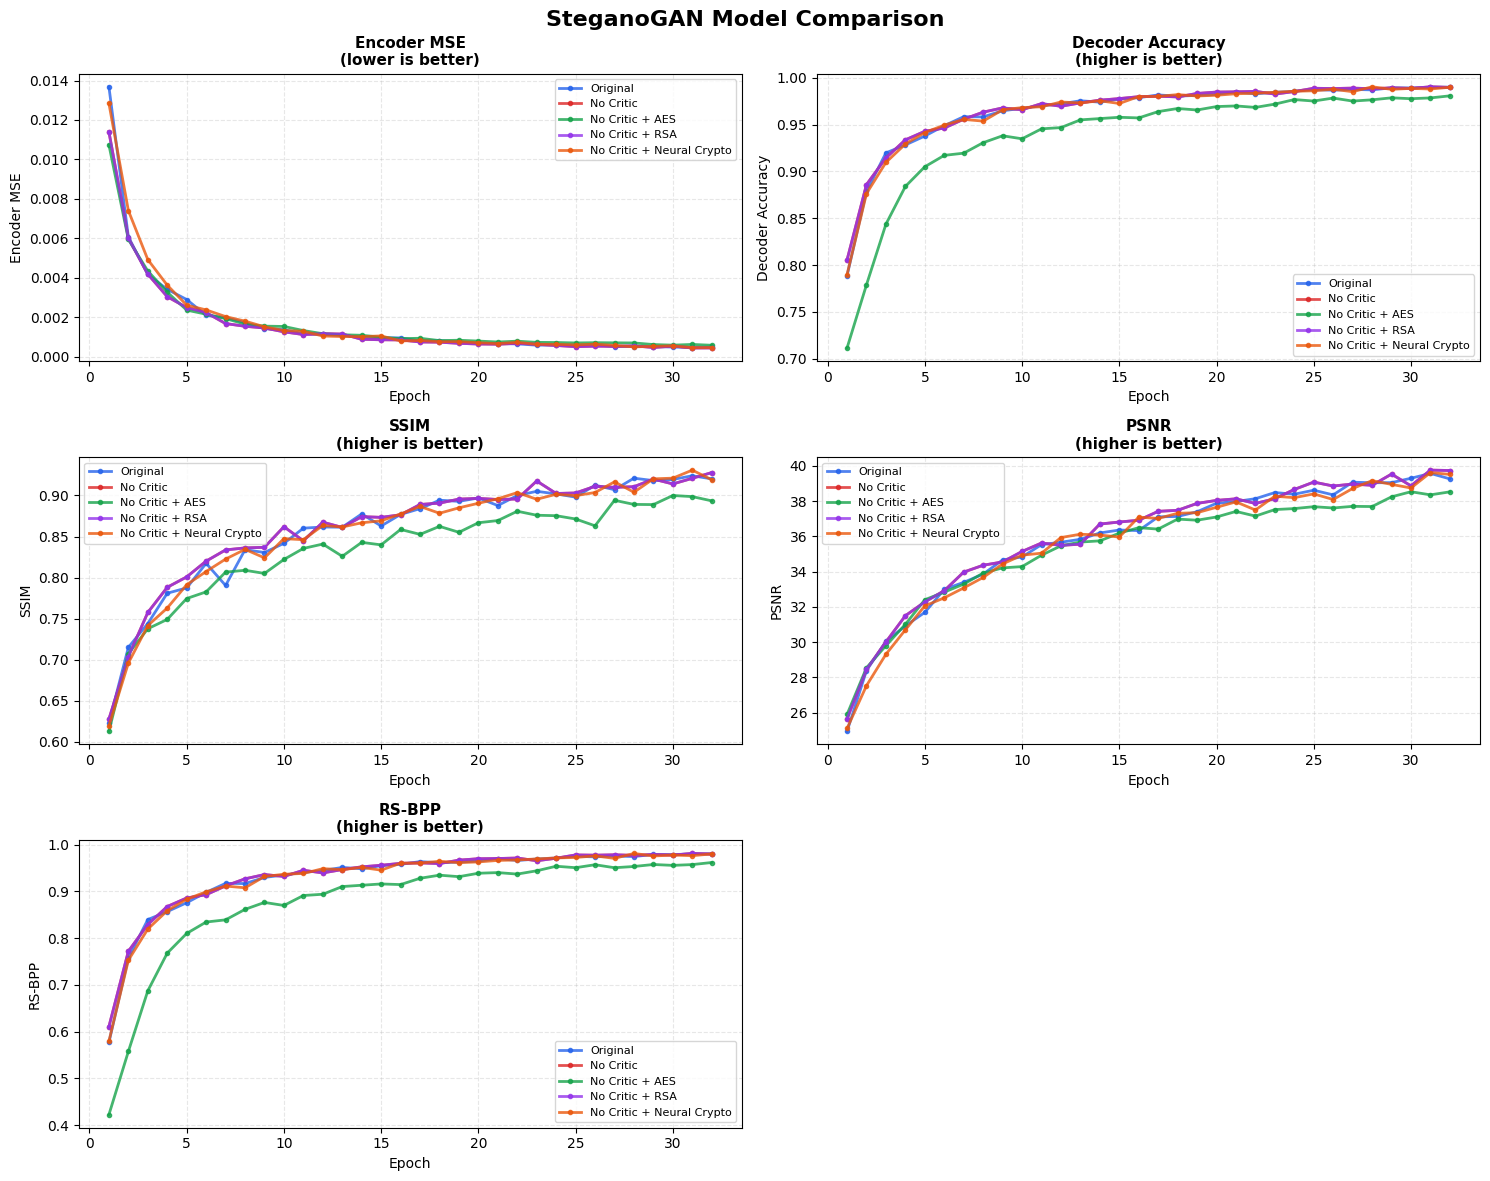


FINAL EPOCH STATISTICS (Epoch 32)

Encoder MSE:
------------------------------------------------------------
  Original                      : 0.000488
  No Critic                     : 0.000436
  No Critic + AES               : 0.000571
  No Critic + RSA               : 0.000436
  No Critic + Neural Crypto     : 0.000457
  Best Model:                    No Critic (0.000436)

Decoder Accuracy:
------------------------------------------------------------
  Original                      : 0.990217
  No Critic                     : 0.989890
  No Critic + AES               : 0.980915
  No Critic + RSA               : 0.989892
  No Critic + Neural Crypto     : 0.990087
  Best Model:                    Original (0.990217)

SSIM:
------------------------------------------------------------
  Original                      : 0.920261
  No Critic                     : 0.927897
  No Critic + AES               : 0.893446
  No Critic + RSA               : 0.927895
  No Critic + Neural Crypto     :

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Define file paths
original_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/original/1752268982/metrics.log'
no_critic_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/custom_nc/1761963794/metrics.log'
no_critic_aes_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/no_critic_with_aes/1761964732/metrics.log'
no_critic_rsa_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/no_critic_with_rsa/1761966304/metrics.log'
no_critic_neural_crypto_logs_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/models/custom_neural_crypto/1761962771/metrics.log'

# Load data from JSON files
def load_metrics(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Load all models
models = {
    'Original': load_metrics(original_logs_path),
    'No Critic': load_metrics(no_critic_logs_path),
    'No Critic + AES': load_metrics(no_critic_aes_logs_path),
    'No Critic + RSA': load_metrics(no_critic_rsa_logs_path),
    'No Critic + Neural Crypto': load_metrics(no_critic_neural_crypto_logs_path)
}

# Define metrics to plot
metrics = [
    ('val.encoder_mse', 'Encoder MSE', 'lower is better'),
    ('val.decoder_acc', 'Decoder Accuracy', 'higher is better'),
    ('val.ssim', 'SSIM', 'higher is better'),
    ('val.psnr', 'PSNR', 'higher is better'),
    ('val.rsbpp', 'RS-BPP', 'higher is better')
]

# Define colors for each model
colors = {
    'Original': '#2563eb',
    'No Critic': '#dc2626',
    'No Critic + AES': '#16a34a',
    'No Critic + RSA': '#9333ea',
    'No Critic + Neural Crypto': '#ea580c'
}

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('SteganoGAN Model Comparison', fontsize=16, fontweight='bold')

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each metric
for idx, (metric_key, metric_label, direction) in enumerate(metrics):
    ax = axes[idx]
    
    # Plot each model
    for model_name, data in models.items():
        epochs = [entry['epoch'] for entry in data]
        values = [entry[metric_key] for entry in data]
        ax.plot(epochs, values, label=model_name, color=colors[model_name], 
                linewidth=2, marker='o', markersize=3, alpha=0.8)
    
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel(metric_label, fontsize=10)
    ax.set_title(f'{metric_label}\n({direction})', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=8)

# Remove the extra subplot
fig.delaxes(axes[5])

# Adjust layout
plt.tight_layout()

# Save figure
output_path = '/Users/dmitryhoma/Projects/phd_dissertation/state_3/NNSteganoGAN/research/metrics_comparison.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {output_path}")

# Show plot
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("FINAL EPOCH STATISTICS (Epoch 32)")
print("="*80)

for metric_key, metric_label, direction in metrics:
    print(f"\n{metric_label}:")
    print("-" * 60)
    for model_name, data in models.items():
        final_value = data[-1][metric_key]
        print(f"  {model_name:30s}: {final_value:.6f}")
    
    # Find best model for this metric
    if 'mse' in metric_key.lower() or 'loss' in metric_key.lower():
        best_model = min(models.items(), key=lambda x: x[1][-1][metric_key])
    else:
        best_model = max(models.items(), key=lambda x: x[1][-1][metric_key])
    print(f"  {'Best Model:':30s} {best_model[0]} ({best_model[1][-1][metric_key]:.6f})")

print("\n" + "="*80)